In [353]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [354]:
data_path = r'C:\Users\narut\OneDrive - University of Hertfordshire\CNN-Data-Science-Project\RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32,

)


Found 4752 files belonging to 9 classes.


In [355]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),   # Randomly flip images horizontally
    RandomRotation(0.4),         # Randomly rotate images by up to 20%
    RandomZoom(0.4),             # Randomly zoom into images by 20%
    RandomBrightness(factor=0.4),        # Randomly increase the brightness
    RandomCrop(150,160)
])

# Apply augmentation to the training data
def augment(image, label):
    return data_augmentation(image), label



In [357]:
class_names = sorted(os.listdir(data_path))  # Get folder names
num_classes = len(class_names) 

In [358]:
def normalize_img(image, label):
    image = image/ 255.0  # Scale pixel values to [0, 1]
    label = tf.one_hot(label, num_classes) 
    return image, label




In [359]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [360]:
# Shuffle and split the dataset into train, validation, and test sets
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

train_dataset = dataset.take(train_size).map(augment).map(normalize_img)
val_dataset = dataset.skip(train_size).take(val_size).map(normalize_img)
test_dataset = dataset.skip(train_size + val_size).map(normalize_img)



In [361]:
for images, labels in train_dataset.take(1):
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")

Min pixel value: 0.0
Max pixel value: 1.0


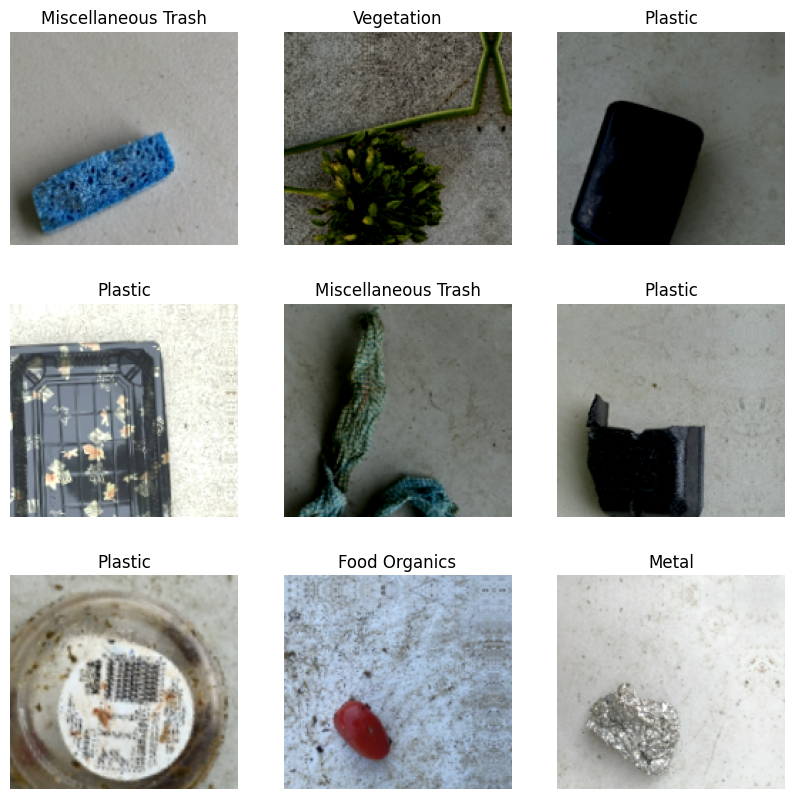

In [362]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Get one batch
        for i in range(9):  # Show 9 images
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()
            plt.imshow(img)
            label_idx = tf.argmax(labels[i]).numpy()  # Extract class index from one-hot label
            plt.title(class_names[label_idx])  
            plt.axis("off")
    plt.show()

# Visualize data augmentation results
visualize_dataset(train_dataset, class_names)

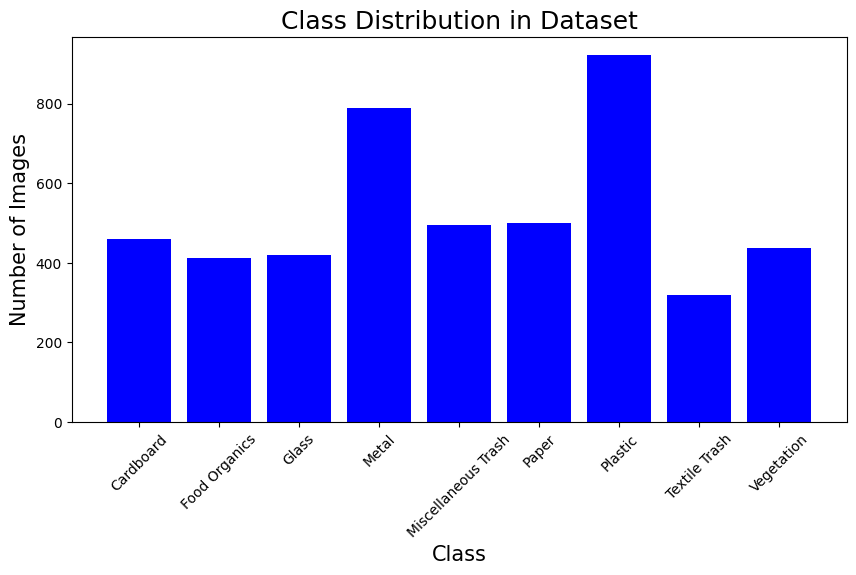

In [363]:


# Count number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name))) 
                for class_name in class_names}

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [364]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Ensure eager execution is enabled
tf.compat.v1.enable_eager_execution()

# Iterate over batches of the training dataset
train_labels = []

# Use .as_numpy_iterator() to convert the TensorFlow dataset to numpy
for batch in train_dataset.as_numpy_iterator():
    labels = batch[1]  # Extract the labels (second element of the batch)
    
    # If labels are one-hot encoded, convert to class indices
    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices
    
    train_labels.extend(labels)  # Add the labels to the list

# Convert the list of labels into a numpy array
train_labels = np.array(train_labels)

# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print out class weights (for reference)
print("Class weights:", class_weights_dict)



Class weights: {0: np.float64(1.1738977072310406), 1: np.float64(1.2663622526636225), 2: np.float64(1.2839506172839505), 3: np.float64(0.6747769667477697), 4: np.float64(1.0687219010918434), 5: np.float64(1.0595351798790194), 6: np.float64(0.5706447187928669), 7: np.float64(1.566854990583804), 8: np.float64(1.2084241103848947)}
